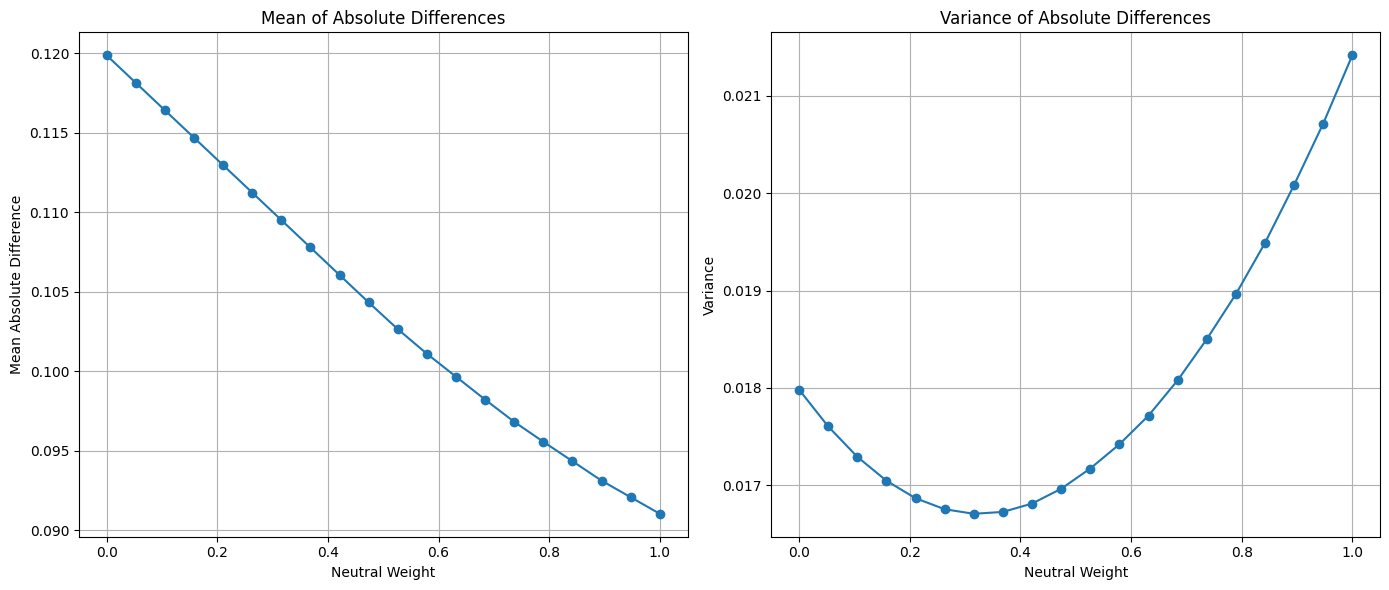

In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt

# 加载数据
def load_data():
    with open('data/complex/raw_ori.json') as f:
        ori = json.load(f)
    with open('data/complex/raw_mod.json') as f:
        mod = json.load(f)
    with open('data/complex/checked_ori.json') as f:
        ori_rc = json.load(f)
    with open('data/complex/checked_mod.json') as f:
        mod_rc = json.load(f)

    return ori, mod, ori_rc, mod_rc

# 计算相似性分数
def calculate_similarities(ori, mod, ori_rc, mod_rc, neutral_weight):
    ori_claims = [o['claims'] for o in ori.values()]
    if len(ori_claims) == 1:
        ori_claims = ori_claims[0]
    ori_len = len(ori_claims)
    mod_claims = [m['claims'] for m in mod.values()]
    mod_len = [len(l) for l in mod_claims]
    mod_op = [m['operations'] for m in mod.values()]

    score_map = {
        1: neutral_weight - 1,
        2: -2,
        3: 0,
        4: 2 * neutral_weight,
        5: neutral_weight - 1,
        6: 0
    }
    scores = [sum(score_map[i] for i in o) for o in mod_op]
    
    gt_sim = [(ori_len + mod_len[i] + scores[i]) / (ori_len + mod_len[i]) for i in range(len(scores))]

    ori_labels_rc = [o['labels'] for o in ori_rc.values()][0]
    mod_labels_rc = [m['labels'] for m in mod_rc.values()]

    weight_map = {
        'Entailment': 1,
        'Contradiction': 0,
        'Neutral': neutral_weight
    }

    rc_sim = []
    for i in range(len(mod_labels_rc)):
        length = len(ori_labels_rc) + len(mod_labels_rc[i])
        weight = sum(weight_map.get(label_ori[i], 0) for label_ori in ori_labels_rc)
        weight += sum(weight_map.get(labels, 0) for labels in mod_labels_rc[i])
        sim = weight / length
        rc_sim.append(sim)

    abs_diff = np.abs(np.array(gt_sim) - np.array(rc_sim))
    mean = np.mean(abs_diff)
    var = np.var(abs_diff)
    
    return mean, var

# 主执行函数
def main():
    ori, mod, ori_rc, mod_rc = load_data()
    neutral_weights = np.linspace(0, 1, 20)
    means, variances = [], []

    for nw in neutral_weights:
        mean, var = calculate_similarities(ori, mod, ori_rc, mod_rc, nw)
        means.append(mean)
        variances.append(var)

    # 绘图
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(neutral_weights, means, marker='o', linestyle='-')
    plt.title('Mean of Absolute Differences')
    plt.xlabel('Neutral Weight')
    plt.ylabel('Mean Absolute Difference')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(neutral_weights, variances, marker='o', linestyle='-')
    plt.title('Variance of Absolute Differences')
    plt.xlabel('Neutral Weight')
    plt.ylabel('Variance')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()
